# Introduction

In this project, we will build a neural network to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](http://yann.lecun.com/exdb/mnist/) and include:

88% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
95.3% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)

MNIST is a great dataset for sanity checking our models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Installation

In [72]:
!pip install matplotlib torchsummary
!pip install -U scikit-learn
# Install requirements
!python -m pip install -r requirements.txt

  Obtaining dependency information for scikit-learn from https://files.pythonhosted.org/packages/96/cf/a714a655266229b51eb2bda117f15275f12457887f165f3c1cc58ab502f1/scikit_learn-1.3.0-cp310-cp310-win_amd64.whl.metadata
  Obtaining dependency information for scipy>=1.5.0 from https://files.pythonhosted.org/packages/70/03/485f73046134400ea25d3cb178c5e6728f9b165f79d09638ecb44ee0e9b1/scipy-1.11.2-cp310-cp310-win_amd64.whl.metadata
  Using cached scipy-1.11.2-cp310-cp310-win_amd64.whl.metadata (59 kB)
  Obtaining dependency information for joblib>=1.1.1 from https://files.pythonhosted.org/packages/10/40/d551139c85db202f1f384ba8bcf96aca2f329440a844f924c8a0040b6d02/joblib-1.3.2-py3-none-any.whl.metadata
  Obtaining dependency information for threadpoolctl>=2.0.0 from https://files.pythonhosted.org/packages/81/12/fd4dea011af9d69e1cad05c75f3f7202cdcbeac9b712eea58ca779a72865/threadpoolctl-3.2.0-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/9.2 MB ? eta -:--:--
   -----

In [145]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F

from torch import nn, optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchsummary import summary
from sklearn.model_selection import train_test_split

In [146]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device, torch.cuda.device_count()

(device(type='cuda'), 1)

## Data Loading & Preprocessing

In [147]:
# Hyperparameters
BATCH_SIZE = 100
EPOCHS = 20
LEARNING_RATE = 0.001

# transforms pipeline
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5), (0.5))])

# training and test sets
orig_data = datasets.MNIST(root="data", download=True, train=True, transform=transform)
test_data = datasets.MNIST(root="data", download=True, train=False, transform=transform)
img_data = datasets.MNIST(root="data", download=True, train=False, transform=transforms.ToTensor())

# create separate copies for training and validation datasets
# train_data, val_data = train_test_split(orig_data, test_size=0.2, random_state=42)
train_data, val_data = random_split(orig_data, [50000, 10000])

# train, test and val loaders 
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_data, batch_size=BATCH_SIZE, shuffle=True)
img_loader = DataLoader(dataset=img_data, batch_size=BATCH_SIZE, shuffle=True)

## EXPLORATORY DATA ANALYSIS


In [167]:
## This cell contains a function for showing 5 images from a dataloader
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    
    for i in range(5):
        print(int(labels[i].detach()))
        
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

1


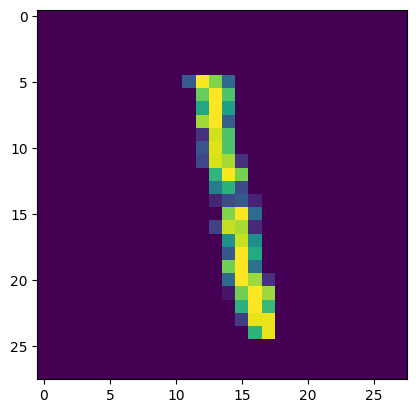

5


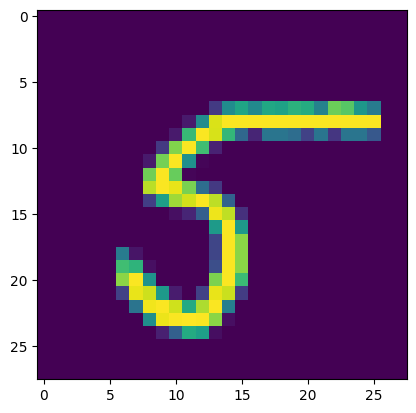

8


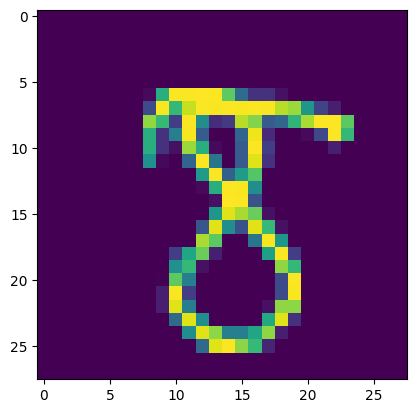

6


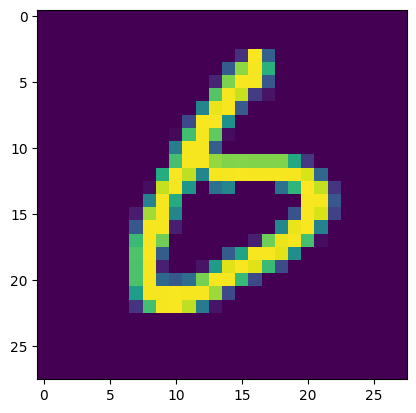

7


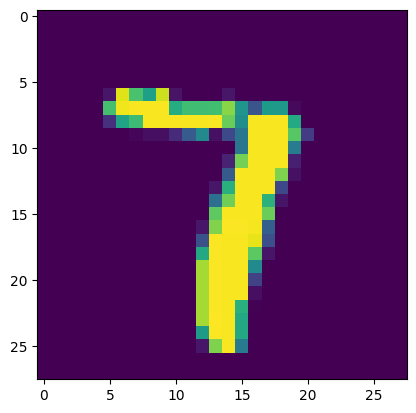

In [149]:
show5(img_loader)

In [150]:
len(train_loader.dataset), len(test_loader.dataset), len(val_loader.dataset)

(50000, 10000, 10000)

## Build the Neural Network

In [164]:
class DigitNet(nn.Module):
    def __init__(self):
        super(DigitNet, self).__init__()
        
        self.fc1 = nn.Linear(in_features=28 * 28, out_features=200)
        self.fc2 = nn.Linear(in_features=200, out_features=150)
        self.fc3 = nn.Linear(in_features=150, out_features=100)
        self.fc4 = nn.Linear(in_features=100, out_features=80)
        self.outfc = nn.Linear(in_features=80, out_features=10)
        
    def forward(self, x):
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.outfc(x)
        
        return x
        
net = DigitNet()
net.to(device)

DigitNet(
  (fc1): Linear(in_features=784, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=150, bias=True)
  (fc3): Linear(in_features=150, out_features=100, bias=True)
  (fc4): Linear(in_features=100, out_features=80, bias=True)
  (outfc): Linear(in_features=80, out_features=10, bias=True)
)

## Check net parameters & layers 

In [165]:
summary(net, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 200]         157,000
            Linear-2                  [-1, 150]          30,150
            Linear-3                  [-1, 100]          15,100
            Linear-4                   [-1, 80]           8,080
            Linear-5                   [-1, 10]             810
Total params: 211,140
Trainable params: 211,140
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.81
Estimated Total Size (MB): 0.81
----------------------------------------------------------------


## Specify a loss function and an optimizer

In [153]:
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

In [154]:
criterion = nn.CrossEntropyLoss()

## Training and Evaluation loop with early stopping

In [155]:
def train(net, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, criterion=criterion, epochs=EPOCHS):
    # track losses for plotting
    train_losses = []
    val_losses = []
    
    best_val_loss = float("inf")
    no_improvement_count = 0
    patience = 3
    
    for epoch in range(epochs):
        net.train()
        
        train_loss = 0.0
        train_correct = 0.0
        for i, data in enumerate(train_loader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = net(inputs)
            
            loss = criterion(outputs, labels)
            loss.backward() # calculate gradients
            optimizer.step() # apply weight update
            
            _, preds = torch.max(outputs.data, 1)
            train_correct += (preds == labels).sum().item()
            train_loss += loss.item()
            
        accuracy = train_correct/len(train_loader)
        avg_loss = train_loss/len(train_loader)
        train_losses.append(avg_loss)  # Store training loss
        print(f'Epoch {epoch + 1} training accuracy: {accuracy:.2f}% training loss: {avg_loss:.5f}')
        
        # Validation on validation set
        val_loss, val_accuracy = evaluate(net, val_loader, criterion)
        val_losses.append(val_loss) # Store val loss
        print(f'Epoch {epoch + 1} val accuracy: {val_accuracy:.2f}% val loss: {val_loss:.5f}')
        
        # Early stopping
        if(val_loss < best_val_loss):
            best_val_loss = val_loss
            no_improvement_count = 0 # reset
        else:
            no_improvement_count += 1
            if(no_improvement_count >= patience):
                print(f'Early stopping after {epoch + 1} epochs with no improvement.')
                break # stop training
    return train_losses, val_losses

def evaluate(net, dataloader, criterion=criterion):
    net.eval()
    val_correct = 0.0
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = net(inputs)

            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs.data, 1)

            val_correct += (preds == labels).sum().item()
            val_loss += loss.item()
            
        accuracy = val_correct/len(dataloader)
        avg_loss = val_loss/len(dataloader)
        
        return avg_loss, accuracy 

## Model test accuracy and loss function

In [156]:
def test(net, data_loader=test_loader, criterion=criterion):
        net.eval()
        test_loss = 0.0
        test_correct = 0.0
        
        with torch.no_grad():
            for inputs, labels in data_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = net(inputs)
                loss = criterion(outputs, labels)

                _, preds = torch.max(outputs.data, 1)
                test_correct += (preds == labels).sum().item()
                test_loss += loss.item()
                
        accuracy = test_correct/len(test_loader)
        avg_loss = test_loss/len(test_loader)
        
        print(f'Test accuracy: {accuracy:.2f}% test loss: {avg_loss:.5f}')

## Plot training and evaluation losses per epoch 

In [157]:
def plot_losses(train_losses, val_losses):
    epochs = len(train_losses)
    x_ticks = np.arange(1, epochs + 1)
    
    plt.plot(x_ticks, train_losses, label="Training Loss")
    plt.plot(x_ticks, val_losses, label="Validation Loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xticks(x_ticks)
    plt.legend()
    plt.show()

## Running the Neural Network

In [158]:
train_losses, val_losses = train(net, epochs=EPOCHS)

Epoch 1 training accuracy: 85.10% training loss: 0.47995
Epoch 1 val accuracy: 92.34% val loss: 0.24821
Epoch 2 training accuracy: 93.87% training loss: 0.19731
Epoch 2 val accuracy: 94.41% val loss: 0.18390
Epoch 3 training accuracy: 95.58% training loss: 0.14318
Epoch 3 val accuracy: 94.96% val loss: 0.16762
Epoch 4 training accuracy: 96.36% training loss: 0.11776
Epoch 4 val accuracy: 96.11% val loss: 0.12643
Epoch 5 training accuracy: 96.81% training loss: 0.09898
Epoch 5 val accuracy: 96.86% val loss: 0.10993
Epoch 6 training accuracy: 97.29% training loss: 0.08568
Epoch 6 val accuracy: 96.63% val loss: 0.10945
Epoch 7 training accuracy: 97.65% training loss: 0.07404
Epoch 7 val accuracy: 97.14% val loss: 0.09661
Epoch 8 training accuracy: 97.70% training loss: 0.07006
Epoch 8 val accuracy: 96.94% val loss: 0.10542
Epoch 9 training accuracy: 97.99% training loss: 0.06129
Epoch 9 val accuracy: 97.34% val loss: 0.09314
Epoch 10 training accuracy: 98.23% training loss: 0.05497
Epoch 

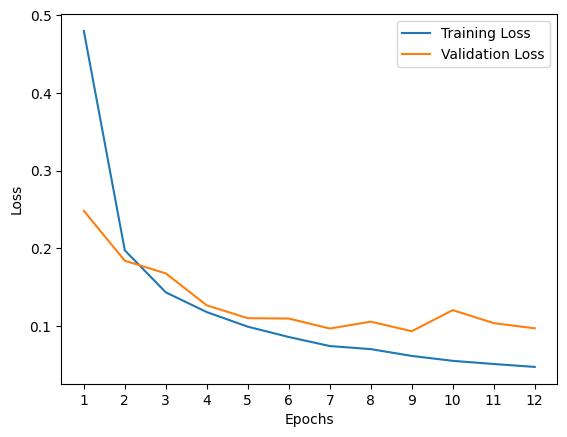

In [159]:
plot_losses(train_losses, val_losses)

## Testing results

In [171]:
test(net)

Test accuracy: 12.03% test loss: 2.30413


## Saving the model

In [172]:
torch.save(net.state_dict(), 'DigitNet.pt')